In [1]:
# default_exp plot

# Import

In [2]:
# export
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from camera_calib_python.cb_geom import cfpgrid
from camera_calib_python.modules import Inverse
from camera_calib_python.utils import *

# Utility

In [3]:
# export
def get_colors(n): return sns.color_palette(None, n)

In [4]:
# export
def plot_cb(M, cb_geom, c, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.gca(projection='3d')
        
    # To make plot more intuitive, I've swapped the Y and Z axes
        
    ps_cb = cfpgrid(cb_geom.h_cb, cb_geom.w_cb)[[0,1,3,2]]
    ps_cb = np.c_[ps_cb, np.zeros(len(ps_cb))]
    ps_cb_root = pmm(ps_cb, M, aug=True)
    ax.add_collection3d(Poly3DCollection([ps_cb_root[:,[0,2,1]]], 
                                         facecolors=c,
                                         edgecolors='k',
                                         alpha=0.5))
    return ax, ps_cb_root

In [5]:
# export
def plot_cam(M, sz_cam, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.gca(projection='3d')
        
    # To make plot more intuitive, I've swapped the Y and Z axes

    ps_axes = np.array([[         0,          0,          0],
                        [2.0*sz_cam,          0,          0],
                        [         0,          0,          0],
                        [         0, 2.0*sz_cam,          0],
                        [         0,          0,          0],
                        [         0,          0, 2.0*sz_cam]])
    ps_text = np.array([[2.5*sz_cam,          0,          0],
                        [         0, 2.5*sz_cam,          0],
                        [         0,          0, 2.5*sz_cam]])
    pss_cam = [[[        0,        0,           0],
                [ sz_cam/2,  sz_cam/2, 1.5*sz_cam],
                [-sz_cam/2,  sz_cam/2, 1.5*sz_cam]],
               [[        0,         0,          0],
                [ sz_cam/2,  sz_cam/2, 1.5*sz_cam],
                [ sz_cam/2, -sz_cam/2, 1.5*sz_cam]],
               [[        0,         0,          0],
                [ sz_cam/2, -sz_cam/2, 1.5*sz_cam],
                [-sz_cam/2, -sz_cam/2, 1.5*sz_cam]],
               [[        0,         0,          0],
                [-sz_cam/2,  sz_cam/2, 1.5*sz_cam],
                [-sz_cam/2, -sz_cam/2, 1.5*sz_cam]],
               [[ sz_cam/2,  sz_cam/2,   sz_cam/2],
                [ sz_cam/2,  sz_cam/2,  -sz_cam/2],
                [-sz_cam/2,  sz_cam/2,  -sz_cam/2],
                [-sz_cam/2,  sz_cam/2,   sz_cam/2]],
               [[ sz_cam/2, -sz_cam/2,   sz_cam/2],
                [ sz_cam/2, -sz_cam/2,  -sz_cam/2],
                [-sz_cam/2, -sz_cam/2,  -sz_cam/2],
                [-sz_cam/2, -sz_cam/2,   sz_cam/2]],
               [[ sz_cam/2,  sz_cam/2,   sz_cam/2],
                [ sz_cam/2,  sz_cam/2,  -sz_cam/2],
                [ sz_cam/2, -sz_cam/2,  -sz_cam/2],
                [ sz_cam/2, -sz_cam/2,   sz_cam/2]],
               [[-sz_cam/2,  sz_cam/2,   sz_cam/2],
                [-sz_cam/2,  sz_cam/2,  -sz_cam/2],
                [-sz_cam/2, -sz_cam/2,  -sz_cam/2],
                [-sz_cam/2, -sz_cam/2,   sz_cam/2]],
               [[ sz_cam/2,  sz_cam/2,   sz_cam/2],
                [ sz_cam/2, -sz_cam/2,   sz_cam/2],
                [-sz_cam/2, -sz_cam/2,   sz_cam/2],
                [-sz_cam/2,  sz_cam/2,   sz_cam/2]],
               [[ sz_cam/2,  sz_cam/2,  -sz_cam/2],
                [ sz_cam/2, -sz_cam/2,  -sz_cam/2],
                [-sz_cam/2, -sz_cam/2,  -sz_cam/2],
                [-sz_cam/2,  sz_cam/2,  -sz_cam/2]]] # TODO: Do one face and rotate it instead
    pss_cam = [np.array(ps_cam) for ps_cam in pss_cam]
    
    ps_axes_root = pmm(ps_axes, M, aug=True)
    ax.quiver(ps_axes_root[::2,0], ps_axes_root[::2,2], ps_axes_root[::2,1],
              ps_axes_root[1::2,0]-ps_axes_root[::2,0],
              ps_axes_root[1::2,2]-ps_axes_root[::2,2],
              ps_axes_root[1::2,1]-ps_axes_root[::2,1],
              color='r')

    ps_text_root = pmm(ps_text, M, aug=True)
    ax.text(*ps_text_root[0, [0,2,1]], 'x')
    ax.text(*ps_text_root[1, [0,2,1]], 'y')
    ax.text(*ps_text_root[2, [0,2,1]], 'z')

    pss_cam_root = [pmm(ps_cam, M, aug=True) for ps_cam in pss_cam]
    ax.add_collection3d(Poly3DCollection([ps_cam_root[:,[0,2,1]] for ps_cam_root in pss_cam_root], 
                                         facecolors='k', 
                                         alpha=0.5))
    
    return ax, np.concatenate([ps_axes_root, ps_text_root] + pss_cam_root)

# Extrinsics plot

In [6]:
# export
def plot_extrinsics(rigids_cb, rigids_cam, cb_geom, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.gca(projection='3d')

    # To make plot more intuitive, I've swapped the Y and Z axes

    # Matplotlib currently has poor support for setting aspect ratio of 3D plots,
    # so keep track of all points, set bounding box, then set box aspect at the end
    ps_all = [] 

    # Plot calibration boards
    for rigid_cb, c in zip(rigids_cb, get_colors(len(rigids_cb))):
        _, ps_cb_root = plot_cb(rigid_cb.get_param(), cb_geom, c, ax)
        ps_all.append(ps_cb_root)

    # Plot cameras
    sz_cam = np.min([cb_geom.h_cb, cb_geom.w_cb])/4 # heuristic; possibly make this an argument
    for rigid_cam in rigids_cam:
        _, ps_cam_root = plot_cam(rigid_cam.get_param(), sz_cam, ax)
        ps_all.append(ps_cam_root)

    # Format plot
    ps_all = np.concatenate(ps_all)
    bb = ps_bb(ps_all)
    ax.set_xlim(bb[0,0], bb[1,0])
    ax.set_ylim(bb[0,2], bb[1,2])
    ax.set_zlim(bb[0,1], bb[1,1])
    ax.set_box_aspect((bb[1]-bb[0])[[0,2,1]])
    ax.invert_zaxis()
    return ax

# Test

In [7]:
[cams, distorts, rigids_cb, rigids_cam, cb_geom] = torch.load('data/dot_vision_checker/calib.pth')
cams, distorts, rigids_cb, rigids_cam, cb_geom

([CamSF(alpha:3.59e+03 x_o:974.5 y_o:763.5),
  CamSF(alpha:3.572e+03 x_o:1.038e+03 y_o:788.0),
  CamSF(alpha:3.48e+03 x_o:1.118e+03 y_o:734.3)],
 [Heikkila97Distortion(k1:-0.1958 k2:1.596 p1:-0.001426 p2:0.001991),
  Heikkila97Distortion(k1:-0.164 k2:0.2276 p1:0.0007354 p2:0.001328),
  Heikkila97Distortion(k1:-0.1556 k2:0.1097 p1:0.0005457 p2:0.0001308)],
 [Rigid(
    (ms): ModuleList(
      (0): EulerRotation(ex:-0.7129 ey:0.1348 ez:2.305)
      (1): Translation(tx:14.52 ty:2.888 tz:184.9)
    )
  ), Rigid(
    (ms): ModuleList(
      (0): EulerRotation(ex:-0.728 ey:-0.1549 ez:1.754)
      (1): Translation(tx:2.485 ty:5.449 tz:175.0)
    )
  )],
 [Rigid(
    (ms): ModuleList(
      (0): EulerRotation(ex:0.0 ey:-0.0 ez:0.0)
      (1): Translation(tx:0.0 ty:0.0 tz:0.0)
    )
  ), Rigid(
    (ms): ModuleList(
      (0): EulerRotation(ex:-0.005198 ey:-0.3905 ez:0.005636)
      (1): Translation(tx:74.48 ty:0.3689 tz:38.29)
    )
  ), Rigid(
    (ms): ModuleList(
      (0): EulerRotation(ex

<Axes3DSubplot:>

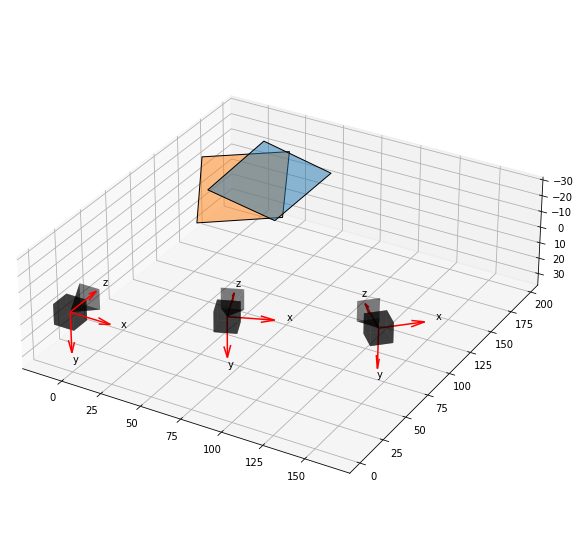

In [8]:
plot_extrinsics(rigids_cb, rigids_cam, cb_geom)

# Build

In [9]:
!nbdev_build_lib

Converted README.ipynb.
Converted calib.ipynb.
Converted cb_geom.ipynb.
Converted control_refine.ipynb.
Converted fiducial_detect.ipynb.
Converted image.ipynb.
Converted modules.ipynb.
Converted plot.ipynb.
Converted utils.ipynb.
